In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg as LA
import gym
import os
import random
import sys
from gym import spaces
from gym.utils import seeding
import copy

from scipy.io import loadmat
import pandapower as pp
import pandapower.networks as pn
import pandas as pd 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import cvxpy as cp

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [2]:
pp_net = pp.converter.from_mpc('pandapower models/pandapower models/case_13.mat', casename_mpc_file='case_mpc')
    
for i in range(1, 13):
    pp.create_sgen(pp_net, i, p_mw = 0, q_mvar=0)

# In the original IEEE 13 bus system, there is no load in bus 3, 7, 8. 
# Add the load to corresponding node for dimension alignment in RL training
pp.create_load(pp_net, 3, p_mw = 0, q_mvar=0)
pp.create_load(pp_net, 7, p_mw = 0, q_mvar=0)
pp.create_load(pp_net, 8, p_mw = 0, q_mvar=0)

11

In [3]:
# assuming each bus has a voltage controller except the root node (0)
injection_bus = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

In [4]:
# Calculate the bus voltage under the default load condition (original p_mw/q_mvar are provided below)
pp.runpp(pp_net, algorithm='bfsw')
pp_net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-2.587188,-1.669742
1,0.944253,-2.730853,0.135000,0.078500
2,0.939130,-2.800610,0.170000,0.125000
3,0.942088,-2.782060,0.000000,0.000000
4,0.937437,-2.829300,0.230000,0.132000
5,0.908391,-4.850139,0.670000,0.381000
6,0.939924,-2.833503,0.230000,0.168000
7,0.906523,-4.915773,0.000000,0.000000
8,0.908391,-4.850139,0.000000,0.000000
9,0.903781,-4.860653,0.170000,0.151000


Text(0, 0.5, 'Voltage')

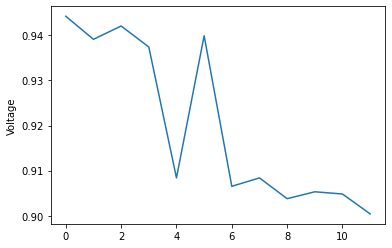

In [5]:
plt.plot(pp_net.res_bus.iloc[injection_bus].vm_pu.to_numpy())
plt.ylabel('Voltage')

In [6]:
pp_net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type,controllable
0,None,1,0.135,0.0785,0.0,0.0,NaN,1.0,True,wye,False
1,None,2,0.170,0.1250,0.0,0.0,NaN,1.0,True,wye,False
2,None,4,0.230,0.1320,0.0,0.0,NaN,1.0,True,wye,False
3,None,5,0.670,0.3810,0.0,0.0,NaN,1.0,True,wye,False
4,None,6,0.230,0.1680,0.0,0.0,NaN,1.0,True,wye,False
5,None,9,0.170,0.1510,0.0,0.0,NaN,1.0,True,wye,False
6,None,10,0.170,0.0800,0.0,0.0,NaN,1.0,True,wye,False
7,None,11,0.128,0.0086,0.0,0.0,NaN,1.0,True,wye,False
8,None,12,0.569,0.2280,0.0,0.0,NaN,1.0,True,wye,False
9,None,3,0.000,0.0000,0.0,0.0,NaN,1.0,True,wye,False


In [7]:
pp_net.shunt

,bus,name,q_mvar,p_mw,vn_kv,step,max_step,in_service


In [8]:
pp_net.trafo

,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,...,tap_neutral,tap_min,tap_max,tap_step_percent,tap_step_degree,tap_pos,tap_phase_shifter,parallel,df,in_service


In [9]:
import scipy
matfile = scipy.io.loadmat('pandapower models/pandapower models/case_13.mat')
print(matfile)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Sun Feb 27 15:47:06 2022', '__version__': '1.0', '__globals__': [], 'case_mpc': array([[(array(['2'], dtype='<U1'), array([[5]], dtype=uint8), array([[1.00e+00, 3.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
                1.00e+00, 1.00e+00, 0.00e+00, 4.16e+00, 1.00e+00, 1.05e+00,
                9.50e-01],
               [2.00e+00, 1.00e+00, 1.35e-01, 7.85e-02, 0.00e+00, 0.00e+00,
                1.00e+00, 1.00e+00, 0.00e+00, 4.16e+00, 1.00e+00, 1.05e+00,
                9.50e-01],
               [3.00e+00, 1.00e+00, 1.70e-01, 1.25e-01, 0.00e+00, 0.00e+00,
                1.00e+00, 1.00e+00, 0.00e+00, 4.16e+00, 1.00e+00, 1.05e+00,
                9.50e-01],
               [4.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
                1.00e+00, 1.00e+00, 0.00e+00, 4.16e+00, 1.00e+00, 1.05e+00,
                9.50e-01],
               [5.00e+00, 1.00e+00, 2.30e-01, 1.32e-01, 0.00e+00, 0.00e+00,
     

In [10]:
pp_net.line

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service,max_loading_percent
0,None,None,0,1,1.0,0.1312,0.3856,0.0,0.0,1373.982612,1.0,1,ol,True,100.0
1,None,None,1,2,1.0,0.1259,0.1276,0.0,0.0,1373.982612,1.0,1,ol,True,100.0
2,None,None,1,3,1.0,0.0713,0.1119,0.0,0.0,1373.982612,1.0,1,ol,True,100.0
3,None,None,2,4,1.0,0.0755,0.0765,0.0,0.0,1373.982612,1.0,1,ol,True,100.0
4,None,None,3,6,1.0,0.0713,0.1119,0.0,0.0,1373.982612,1.0,1,ol,True,100.0
5,None,None,1,5,1.0,0.1312,0.3856,0.0,0.0,1373.982612,1.0,1,ol,True,100.0
6,None,None,5,7,1.0,0.0752,0.0771,0.0,0.0,1373.982612,1.0,1,ol,True,100.0
7,None,None,7,10,1.0,0.0755,0.0766,0.0,0.0,1373.982612,1.0,1,ol,True,100.0
8,None,None,7,11,1.0,0.2034,0.0766,0.0,0.0,1373.982612,1.0,1,ol,True,100.0
9,None,None,5,8,1.0,0.0656,0.1928,0.0,0.0,1373.982612,1.0,1,ol,True,100.0


In [11]:
A=-np.eye(12)

In [12]:
A[1,0]=1
A[2,0]=1
A[3,0]=1
A[4,1]=1
A[5,2]=1
A[6,2]=1
A[7,2]=1
A[8,3]=1
A[9,5]=1
A[10,5]=1
A[11,7]=1
# how this adjecent matrix is built:
# lines(rows):0-1,1-2,1-5,1-3,2-4,5-7,5-8,5-9,3-6,7-10,7-11,9-12
# buses (columns):1,2,5,3,4,7,8,9,6,10,11,12


In [13]:
A

array([[-1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [ 1., -1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [ 1., -0., -1., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [ 1., -0., -0., -1., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0.,  1., -0., -0., -1., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0.,  1., -0., -0., -1., -0., -0., -0., -0., -0., -0.],
       [-0., -0.,  1., -0., -0., -0., -1., -0., -0., -0., -0., -0.],
       [-0., -0.,  1., -0., -0., -0., -0., -1., -0., -0., -0., -0.],
       [-0., -0., -0.,  1., -0., -0., -0., -0., -1., -0., -0., -0.],
       [-0., -0., -0., -0., -0.,  1., -0., -0., -0., -1., -0., -0.],
       [-0., -0., -0., -0., -0.,  1., -0., -0., -0., -0., -1., -0.],
       [-0., -0., -0., -0., -0., -0., -0.,  1., -0., -0., -0., -1.]])

In [14]:
X = np.diag([0.3856,0.1276,0.3856,0.1119,0.0765,0.0771,0.1928,0.0423,0.1119,0.0766,0.0766,0.0423])

In [15]:
F = -np.linalg.inv(A)

In [16]:
XX =2*F@X@F.T

In [17]:
XX

array([[0.7712, 0.7712, 0.7712, 0.7712, 0.7712, 0.7712, 0.7712, 0.7712,
        0.7712, 0.7712, 0.7712, 0.7712],
       [0.7712, 1.0264, 0.7712, 0.7712, 1.0264, 0.7712, 0.7712, 0.7712,
        0.7712, 0.7712, 0.7712, 0.7712],
       [0.7712, 0.7712, 1.5424, 0.7712, 0.7712, 1.5424, 1.5424, 1.5424,
        0.7712, 1.5424, 1.5424, 1.5424],
       [0.7712, 0.7712, 0.7712, 0.995 , 0.7712, 0.7712, 0.7712, 0.7712,
        0.995 , 0.7712, 0.7712, 0.7712],
       [0.7712, 1.0264, 0.7712, 0.7712, 1.1794, 0.7712, 0.7712, 0.7712,
        0.7712, 0.7712, 0.7712, 0.7712],
       [0.7712, 0.7712, 1.5424, 0.7712, 0.7712, 1.6966, 1.5424, 1.5424,
        0.7712, 1.6966, 1.6966, 1.5424],
       [0.7712, 0.7712, 1.5424, 0.7712, 0.7712, 1.5424, 1.928 , 1.5424,
        0.7712, 1.5424, 1.5424, 1.5424],
       [0.7712, 0.7712, 1.5424, 0.7712, 0.7712, 1.5424, 1.5424, 1.627 ,
        0.7712, 1.5424, 1.5424, 1.627 ],
       [0.7712, 0.7712, 0.7712, 0.995 , 0.7712, 0.7712, 0.7712, 0.7712,
        1.2188, 0.7712, 

In [85]:
Ybus = np.load('Ybus.npy')
print(Ybus.imag)

[[ -8.04461384   8.04461384   0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [  8.04461384 -51.83252266  13.74427604  21.99901893   0.
    8.04461384   0.           0.           0.           0.
    0.           0.           0.        ]
 [  0.          13.74427604 -36.66361644   0.          22.9193404
    0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [  0.          21.99901893   0.         -43.99803786   0.
    0.          21.99901893   0.           0.           0.
    0.           0.           0.        ]
 [  0.           0.          22.9193404    0.         -22.9193404
    0.           0.           0.           0.           0.
    0.           0.           0.        ]
 [  0.           8.04461384   0.           0.           0.
  -66.64806687   0.          23.00560389  16.08922768  19.50862145
    0.           0.           0.        ]
 [  0.           0

In [80]:
Xbus = np.linalg.inv(Ybus)
print(Xbus)

[[-3.51614805e+13-4.54169123e+13j -3.51614805e+13-4.54169123e+13j
  -3.51614805e+13-4.54169123e+13j -3.51614805e+13-4.54169123e+13j
  -3.51614805e+13-4.54169123e+13j -3.51614805e+13-4.54169123e+13j
  -3.51614805e+13-4.54169123e+13j -3.51614805e+13-4.54169123e+13j
  -3.51614805e+13-4.54169123e+13j -3.51614805e+13-4.54169123e+13j
  -3.51614805e+13-4.54169123e+13j -3.51614805e+13-4.54169123e+13j
  -3.51614805e+13-4.54169123e+13j]
 [-3.51614805e+13-4.54169123e+13j -3.51614805e+13-4.54169123e+13j
  -3.51614805e+13-4.54169123e+13j -3.51614805e+13-4.54169123e+13j
  -3.51614805e+13-4.54169123e+13j -3.51614805e+13-4.54169123e+13j
  -3.51614805e+13-4.54169123e+13j -3.51614805e+13-4.54169123e+13j
  -3.51614805e+13-4.54169123e+13j -3.51614805e+13-4.54169123e+13j
  -3.51614805e+13-4.54169123e+13j -3.51614805e+13-4.54169123e+13j
  -3.51614805e+13-4.54169123e+13j]
 [-3.51614805e+13-4.54169123e+13j -3.51614805e+13-4.54169123e+13j
  -3.51614805e+13-4.54169123e+13j -3.51614805e+13-4.54169123e+13j
  -3.5

In [18]:
np.max(np.linalg.eigvals(XX))
np.min(np.linalg.eigvals(XX))
# So XX is positive definite

0.025732389209492265

In [84]:
XX_inv = np.linalg.inv(XX) 
print(XX_inv)
print(np.min(np.linalg.eigvals(XX_inv)))

[[ 1.09801315e+01 -3.91849530e+00 -1.29668050e+00 -4.46827525e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -5.75841818e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.91849530e+00  1.04544430e+01  0.00000000e+00  0.00000000e+00
  -6.53594771e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.29668050e+00  0.00000000e+00  2.21954568e+01  0.00000000e+00
   0.00000000e+00 -6.48508431e+00 -2.59336100e+00 -1.18203310e+01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.46827525e+00  0.00000000e+00  0.00000000e+00  8.93655049e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -4.46827525e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -6.53594771e+00  0.00000000e+00  0.00000000e+00
   6.53594771e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.

In [20]:
print(np.max(np.linalg.eigvals(XX_inv)))

38.861529407891936


In [21]:
from env_single_phase_13bus import IEEE13bus, create_13bus
net = create_13bus()
injection_bus = np.array([1,2,5,3,4,7,8,9,6,10,11,12])
env = IEEE13bus(net, injection_bus)
# env.reset(0)
# print(env.network.res_bus)
# print(env.network.sgen.at[0, 'p_mw'])

In [ ]:
#Suppose q = 0, then v(0) should be v^{par}
# thus the optimal solution q* = (C+X)^{-1}(v^{nom}-v^{par})

In [57]:
max_ac = 0.3
ph_num = 1
slope = 1
num_agent = len(injection_bus)
def test_suc_rate(algm, step_num=100):
    success_num = 0
    final_state_list = []
    final_step_list = []
    control_cost_list = []
    steady_cost_list = []
    for rep in range(500):
        state = env.reset(rep)
        episode_reward = 0
        last_action = np.zeros((num_agent,ph_num))
        action_list=[]
        state_list =[]
        state_list.append(state)
        control_action = []
        for step in range(step_num):
            action = slope*(np.maximum(state-1.03, np.zeros_like(state))-np.maximum(0.97-state, np.zeros_like(state))).reshape((num_agent,ph_num))
            action = np.clip(action, -max_ac, max_ac)
            # PI policy    
            action = last_action - np.asarray(action)
            control_action.append(np.abs(action))
            # execute action a_t and observe reward r_t and observe next state s_{t+1}
            next_state, reward, reward_sep, done = env.step_Preward(action, (last_action-action))
            # done = False
            if done:
                success_num += 1
                final_step_list.append(step+1)
                control_cost_list.append(np.sum(np.asarray(control_action)))
                break
            action_list.append(last_action-action)
            state_list.append(next_state)
            last_action = np.copy(action)
            state = next_state
        
        if not done:
            final_step_list.append(step_num)
            control_cost_list.append(np.sum(np.asarray(control_action)))
        final_state_list.append(next_state)
        steady_cost = action.T@C@action + action.T@(state-np.ones_like(state))
        steady_cost_list.append(steady_cost)
    print(f'result for {algm}')
    print(success_num)
    print(np.mean(final_step_list), np.std(final_step_list))
    print('cost',np.mean(control_cost_list), np.std(control_cost_list))
    print('steady cost',np.mean(steady_cost_list), np.std(steady_cost_list))
    return final_state_list

In [58]:
final_state = test_suc_rate('linear')
# basic linear controller

result for linear
500
6.036 3.792453559372877
cost 5.787603919027364 3.651168675857616
steady cost -0.036423537844375985 0.021363457766955342


In [ ]:
C = np.diag([0.5,0.7,0.5,0.7,1.0,0.7,1.0,0.7,1.0,1.0,1.0,1.0])*0.01

In [162]:
def test_suc_rate_grad(algm, step_num=1000,gamma=0.1):
    success_num = 0
    final_state_list = []
    final_step_list = []
    control_cost_list = []
    steady_cost_list = []
    for rep in range(1):
        state = env.reset(rep)
        episode_reward = 0
        last_action = np.zeros((num_agent,ph_num))
        action_list=[]
        state_list =[]
        state_list.append(state)
        control_action = []
        vpar = state.copy()
        for step in range(step_num):
            action = slope*(np.maximum(state-1.03, np.zeros_like(state))-np.maximum(0.97-state, np.zeros_like(state))).reshape((num_agent,ph_num))
            # if np.inner(action.reshape(-1), (gamma*XX_inv@(C@last_action + state.reshape((num_agent,ph_num)) - np.ones_like(last_action))).reshape(-1))<0:
            #     print("different direction")
            action += gamma*XX_inv@(C@last_action + state.reshape((num_agent,ph_num)) - np.ones_like(last_action))
            
            # print('action g',(slope*(np.maximum(state-1.03, np.zeros_like(state))-np.maximum(0.97-state, np.zeros_like(state))).reshape((num_agent,ph_num)))[0])
            # print('gradient', (gamma*XX_inv@(C@last_action + state.reshape((num_agent,ph_num)) - 1))[0])
            
            action = np.clip(action, -max_ac, max_ac)
            # PI policy    
            action = last_action - np.asarray(action)
            control_action.append(np.abs(action))
            # execute action a_t and observe reward r_t and observe next state s_{t+1}
            next_state, reward, reward_sep, done = env.step_Preward(action, (last_action-action))
            done = False
            if done:
                success_num += 1
                final_step_list.append(step+1)
                control_cost_list.append(np.sum(np.asarray(control_action)))
                break
            action_list.append(last_action-action)
            state_list.append(next_state)
            last_action = np.copy(action)
            state = next_state
        error = np.linalg.norm(action- np.linalg.inv(C+XX)@(np.ones_like(state)-vpar))
        # print(slope*(np.maximum(state-1.03, np.zeros_like(state))-np.maximum(0.97-state, np.zeros_like(state))).reshape((num_agent,ph_num)))
        print(np.linalg.norm(C@last_action + state.reshape((num_agent,ph_num)) - np.ones_like(last_action)))
        # print(error)
        
        if not done:
            final_step_list.append(step_num)
            control_cost_list.append(np.sum(np.asarray(control_action)))
        final_state_list.append(next_state)
        steady_cost = action.T@C@action + action.T@(state-np.ones_like(state))
        steady_cost_list.append(steady_cost)
        
    print(f'result for {algm}')
    print(success_num)
    print(np.mean(final_step_list), np.std(final_step_list))
    print('cost',np.mean(control_cost_list), np.std(control_cost_list))
    print('steady cost',np.mean(steady_cost_list), np.std(steady_cost_list))
    return final_state_list

In [163]:
final_state_grad = test_suc_rate_grad('linear')

0.0004240150946821555
result for linear
0
1000.0 0.0
cost 2543.117017097933 0.0
steady cost 0.0002395697655548576 0.0


In [59]:
deno = 3*max(np.linalg.eigvals(XX+C))
print(deno)

40.570741868100114


In [152]:
up = 2*np.sqrt(min(np.linalg.eigvals(XX.T@XX)))
print(up)

0.05146477841898024


In [133]:
print(up/deno)

0.0012685195303131953


In [155]:
deno = 3*max(np.linalg.eigvals(C@XX_inv+np.eye(XX.shape[0])))
print(deno)

10.996106309938034


In [157]:
print(2/deno)

0.18188256312076984
